In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-02 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

Data Source: Bayerische Landesamt für Gesundheit und Lebensmittelsicherheit (LGL): [Übersicht der Fallzahlen von Coronavirusinfektionen](https://www.lgl.bayern.de/gesundheit/infektionsschutz/infektionskrankheiten_a_z/coronavirus/karte_coronavirus/index.htm)

[web-scraping-tutorial-python](https://www.dataquest.io/blog/web-scraping-tutorial-python/)

In [5]:
import requests
import urllib.request
import time
import bs4
import re
# from bs4 import BeautifulSoup

In [6]:
import decimal
import locale

In [7]:
import dateparser

In [8]:
url = 'https://www.lgl.bayern.de/gesundheit/infektionsschutz/infektionskrankheiten_a_z/coronavirus/karte_coronavirus/index.htm'
response = requests.get(url)

In [9]:
response

<Response [200]>

In [10]:
soup = bs4.BeautifulSoup(response.text, "html.parser")

In [11]:
# soup.find_all(class_="accordion")

In [12]:
tableFaelle = soup.find(id="tableFaelle")

In [13]:
# tableFaelle

In [14]:
# dateparser.parse('01. Mrz 2020', date_formats=['%d. %b %Y'], languages=['de'])

In [15]:
# dateparser.parse('01. Mar 2020', date_formats=['%d. %b %Y'], languages=['de'])

In [16]:
# dateparser.parse('01. März 2020', languages=['de'])

In [17]:
locale.setlocale(locale.LC_ALL, 'de_DE.UTF8')
df = pd.DataFrame(columns=['report_date', 'new_confirmed'])
for i, tr in enumerate(tableFaelle.find_all('tr')):
    if i == 0:
        continue
        
    td    = tr.find_all('td')
    dtstr = td[0].text + ' 2020'
    dtstr = re.sub('Mrz','März', dtstr)
    dt = pd.to_datetime(dateparser.parse(dtstr, languages=['de']))
    ct = locale.atof(td[1].text, decimal.Decimal)
    
    df.loc[i] = [dt, ct]
df   = df.set_index('report_date')
df['confirmed'] = df.new_confirmed.cumsum()
df = df[['confirmed', 'new_confirmed']]
df = df.astype(np.float)
df = df[df.index < pd.to_datetime(datetime.datetime.now().date())]
df.tail()

,confirmed,new_confirmed
report_date,,
2020-03-28,14286.0,1441.0
2020-03-29,15122.0,836.0
2020-03-30,16085.0,963.0
2020-03-31,17589.0,1504.0
2020-04-01,19081.0,1492.0


In [18]:
today_string = datetime.datetime.now().date().strftime('%Y-%m-%d')
today_string

'2020-04-02'

In [19]:
bavaria_df = df.copy()

In [20]:
bavaria_df.to_excel("bavaria_covid19_data.xlsx") 

In [21]:
bavaria_df.to_excel(today_string +"_bavaria_covid19_data.xlsx") 

Bavaria first dead person date: `2020-03-12`

[Liste der deutschen Bundesländer nach Bevölkerung](https://de.wikipedia.org/wiki/Liste_der_deutschen_Bundesl%C3%A4nder_nach_Bev%C3%B6lkerung)

In [22]:
einwohner_deutschland = 83019213.0
einwohner_bayern      = 13076721.0
prozent_bayern        = einwohner_bayern / einwohner_deutschland
prozent_bayern

0.15751439368619405

[Bevölkerung Europa](https://www.indexmundi.com/map/?v=21&r=eu&l=de)

In [23]:
einwohner_österreich = 8793370.0
prozent_österreich   = einwohner_österreich / einwohner_deutschland
prozent_österreich

0.10591969837150829

In [24]:
new_confirmed_threshold = 100.0 * prozent_bayern // 1 + 1
new_confirmed_threshold

16.0

2020-04-20 00:00:00 [23947.52950397     0.23949688    -9.73232115] 0.058662559293713556


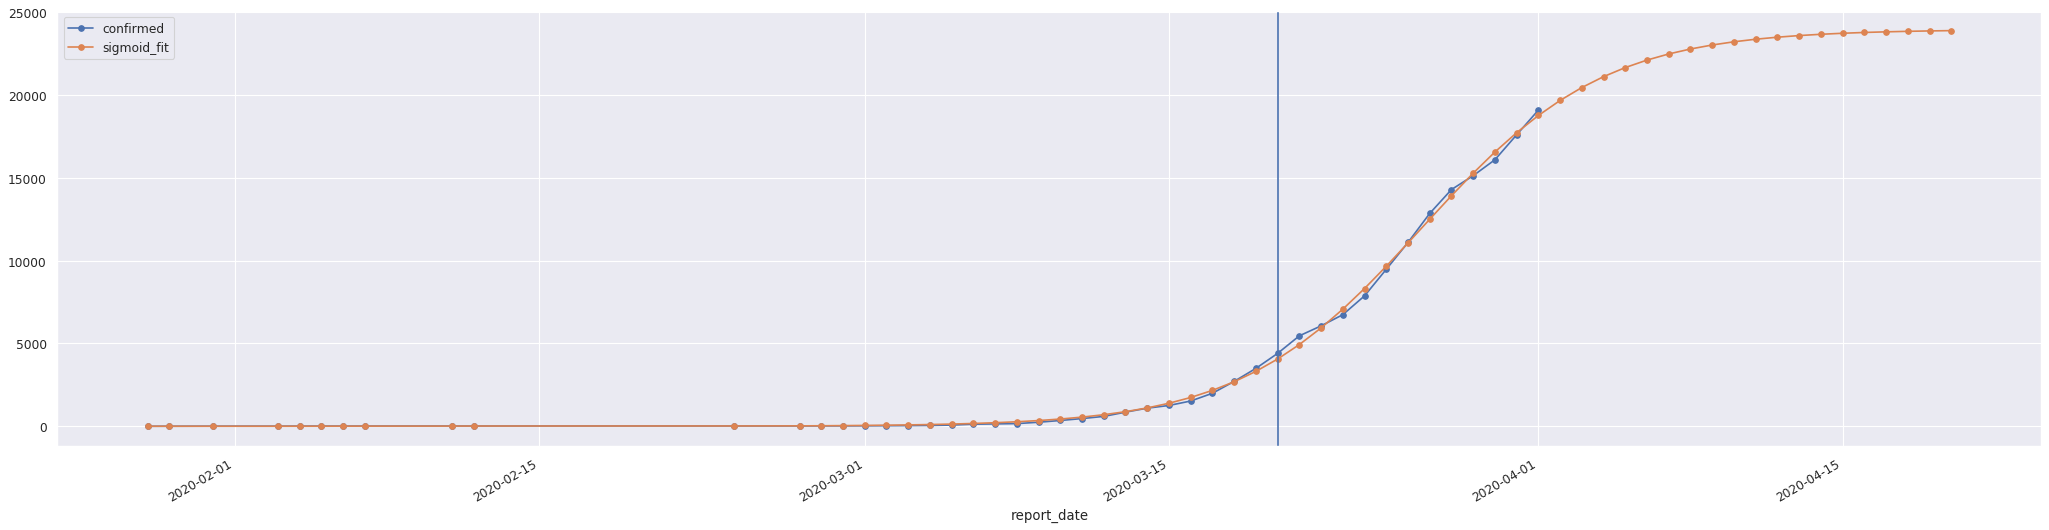

In [25]:
country_name, first_date, init_add, restriction_start_date = 'Bavaria', pd.to_datetime('2020-03-12'), 500.0, datetime.datetime(2020, 3, 20)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add, in_df=bavaria_df, new_confirmed_threshold=new_confirmed_threshold)
print(ldf.index[-1], lpopt, lgrowthRate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', 'sigmoid_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

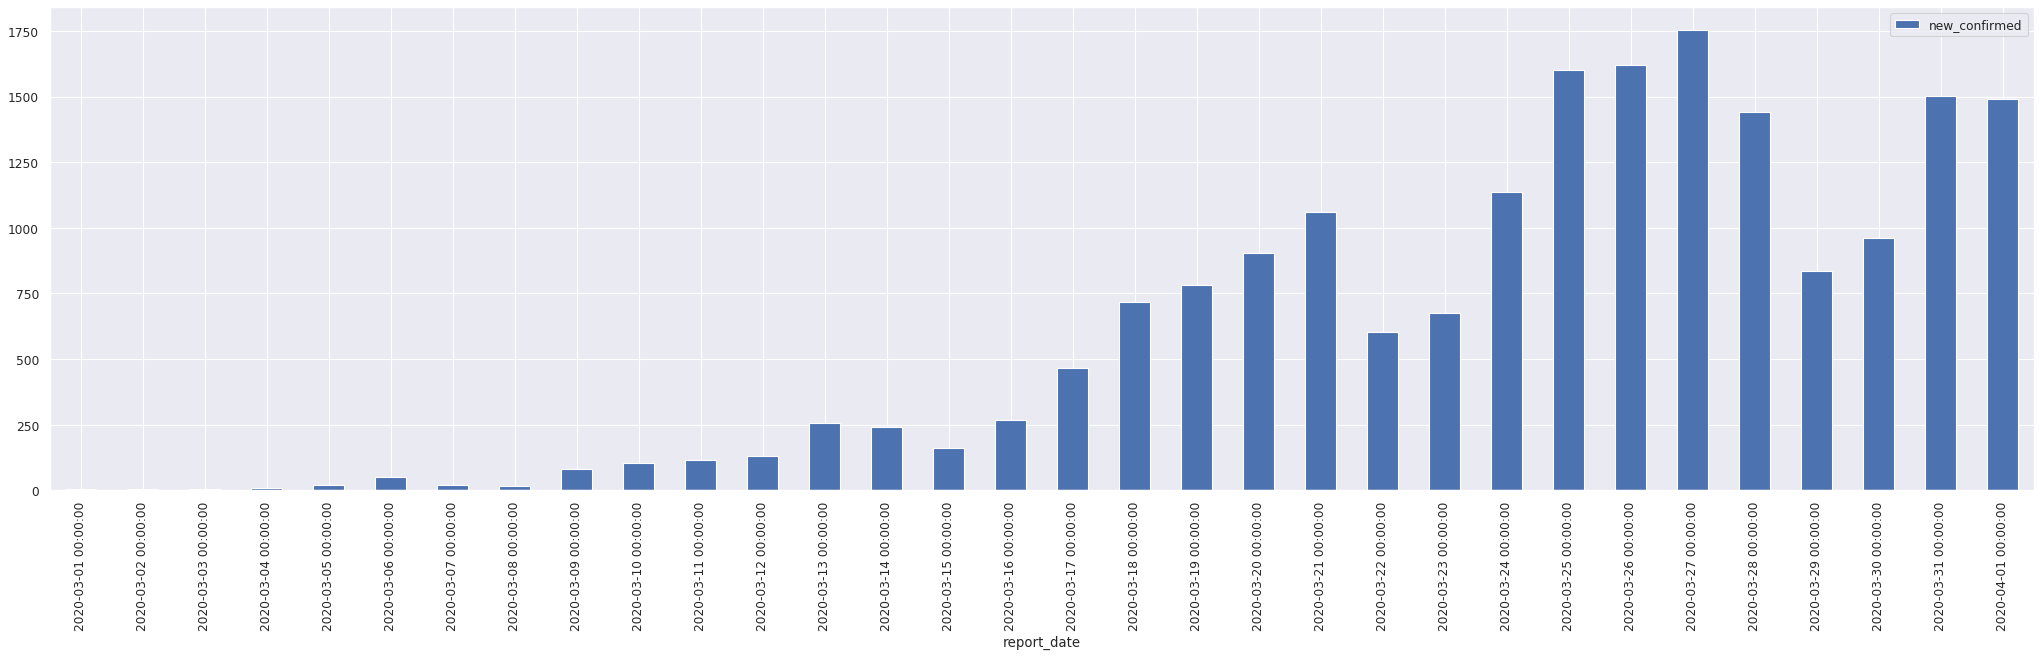

In [26]:
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf = bavaria_df[['new_confirmed']]
ldf = ldf[ldf.index >= pd.to_datetime('2020-03-01')]
ldf.plot.bar(ax=ax)

In [27]:
austria_new_confirmed_threshold = 100.0 * prozent_österreich // 1 + 1
austria_new_confirmed_threshold

11.0

2020-04-21 00:00:00 [13859.60204654     0.20824181    -2.87799922] 0.0424036931048517


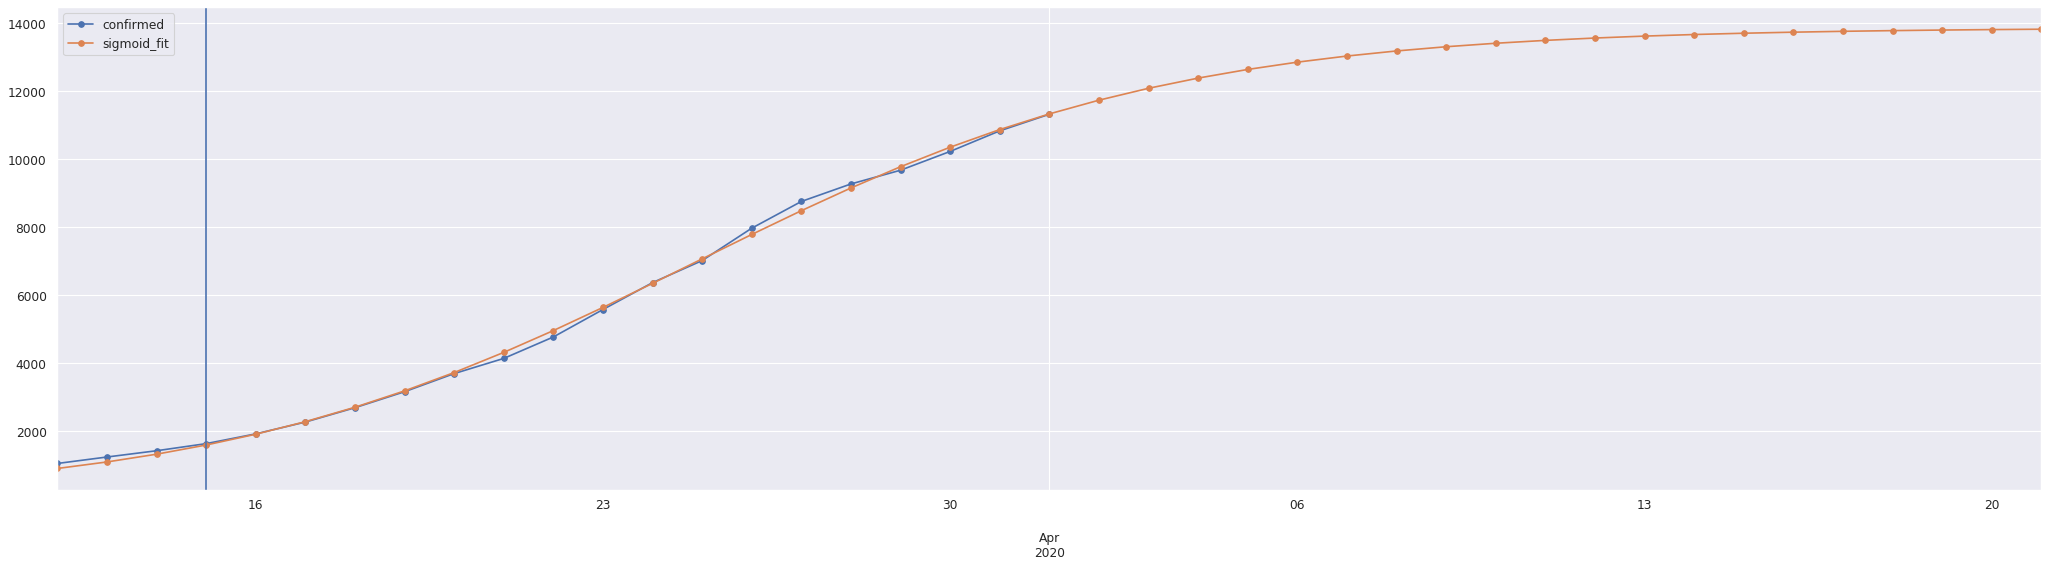

In [28]:
# country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-02-19'), 600, datetime.datetime(2020, 3, 15)
country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-03-12'), 600, datetime.datetime(2020, 3, 15)
# country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-03-12'), 0, datetime.datetime(2020, 3, 15)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add, new_confirmed_threshold=austria_new_confirmed_threshold)
print(ldf.index[-1], lpopt, lgrowthRate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', 'sigmoid_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);